# Group B: Fuel Price Analysis

This project aims at taking historical data of petrol prices and crude oil, and using this to attempt to create a predictive model to, as accuratly as possible, predict fuel prices accross New South Wales (Australia). As a secondary objective, we aim to see if there is a marked difference between petrol prices depending on region. To do this, we will compare petrol prices in NSW based upon postcode. 

### Outline
1. Import Data
2. Cleaning of Data
3. Outlier Analyis
4. Resampling to averages
5. Seperation of unlike types
6. Analysis of Correlation
7. Calculation of Relationship
8. Comments on Diesel
9. Relationship between Petrol and Crude Oil
10. Analysing Petrol Price by Location
11. References

In [186]:
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
import seaborn as sns
import math
import statsmodels.api as sm
from numpy import NaN
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
matplotlib.style.use('ggplot')
from sklearn import metrics
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from __future__ import print_function
from sklearn.decomposition import PCA
%matplotlib inline

### 1. Import Data
Start by importing all datasets and cleaning of unessessary variables.

In [187]:
# this takes some time
dateParseDM = lambda dates: dateutil.parser.parse(dates, dayfirst=True)
dateParseMD = lambda dates: dateutil.parser.parse(dates)

# petrol
sixOct = pd.read_csv('files/FuelCheck/16_10.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseDM)
sixNov = pd.read_csv('files/FuelCheck/16_11.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseMD)
sixDec = pd.read_csv('files/FuelCheck/16_12.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseMD)
sevJan = pd.read_csv('files/FuelCheck/17_01.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseDM)
sevFeb = pd.read_csv('files/FuelCheck/17_02.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseDM)
sevMar = pd.read_csv('files/FuelCheck/17_03.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseDM)
sevApr = pd.read_csv('files/FuelCheck/17_04.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseDM)
sevMay = pd.read_csv('files/FuelCheck/17_05.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseDM)
sevJun = pd.read_csv('files/FuelCheck/17_06.csv', parse_dates=['PriceUpdatedDate'], index_col=['PriceUpdatedDate'], date_parser=dateParseDM)

# crude oil
crudeOil = pd.read_csv('files/CrudeOil/Crude_Oil_Historical_Data.csv', parse_dates=['Date'], index_col=['Date'], date_parser=dateParseMD)

In [188]:
# merge monthly dataframes
monthlyFrames = [sixOct, sixNov, sixDec, sevJan, sevFeb, sevMar, sevApr, sevMay, sevJun]
petrol = pd.concat(monthlyFrames)

# drop unesessary petrol variables
columnsPetrol = ['ServiceStationName', 'Address', 'Suburb']
petrol.drop(columnsPetrol, axis=1, inplace=True)

## Analysing and Cleaning Petrol Prices

Just average all petrol stations (irrespective of postcode and brand) in state, and compare to crude oil.

As fuel-type is a variable, prices must first be split accrodingly.

### 2. Cleaning of Data

In [189]:
crudeOil.head()
petrol.groupby(['FuelCode'])['Price'].mean()

FuelCode
B20    110.650000
CNG     72.800000
DL     124.119659
E10    121.704238
E85    109.418249
LPG     71.022797
P95    137.396406
P98    142.950428
PDL    125.348303
U91    124.132665
Name: Price, dtype: float64

With too many fuel types, we will isolate working with major fuel-types.

In [190]:
petrol.groupby(['FuelCode'])['Price'].count().sort_values(ascending=False)

FuelCode
E10    123004
P98    122317
U91    120715
P95    107098
PDL     19887
DL      15662
LPG      4676
E85      1348
B20         4
CNG         2
Name: Price, dtype: int64

We will isolate the top 6 fuel types (x4 Petrol, x2 Diesel)

In [191]:
petrolE10 = petrol[petrol.FuelCode == 'E10']
petrolU91 = petrol[petrol.FuelCode == 'U91']
petrolP95 = petrol[petrol.FuelCode == 'P95']
petrolP98 = petrol[petrol.FuelCode == 'P98']
petrolDL  = petrol[petrol.FuelCode == 'DL' ]
petrolPDL = petrol[petrol.FuelCode == 'PDL']

Firstly we need to check and clean outliers

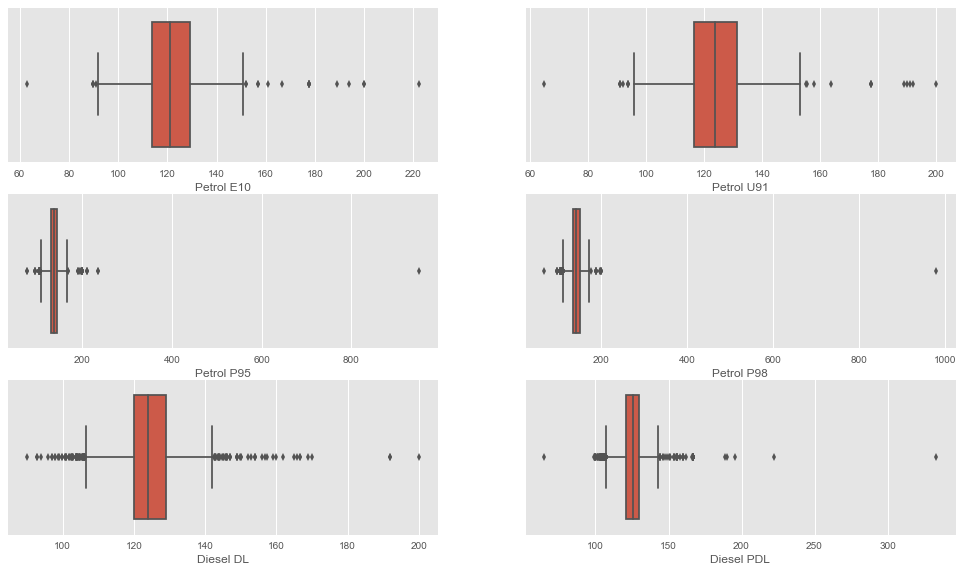

In [192]:
plt.subplot(621)
sns.boxplot(petrolE10["Price"])
plt.xlabel("Petrol E10")

plt.subplot(622)
sns.boxplot(petrolU91["Price"])
plt.xlabel("Petrol U91")

plt.subplot(623)
sns.boxplot(petrolP95["Price"])
plt.xlabel("Petrol P95")

plt.subplot(624)
sns.boxplot(petrolP98["Price"])
plt.xlabel("Petrol P98")

plt.subplot(625)
sns.boxplot(petrolDL["Price"])
plt.xlabel("Diesel DL")

plt.subplot(626)
sns.boxplot(petrolPDL["Price"])
plt.xlabel("Diesel PDL")

fig = plt.gcf()
fig.set_size_inches((17,20))

### 3. Outlier Analyis

While the above plots show some outliers, it is hard to detect if they should be removed, as they are from a non-stationary time series. We will now plot them, and attempt to remove outliers.

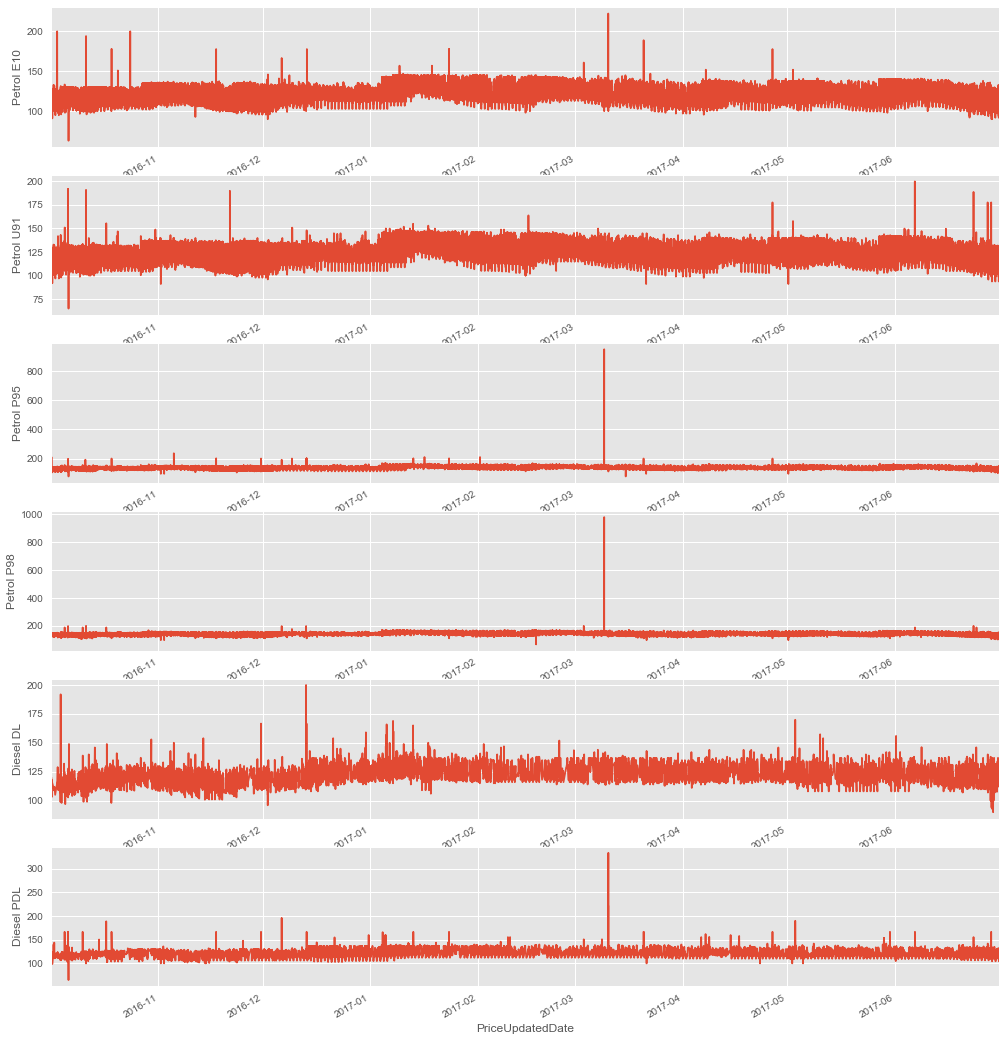

In [193]:
plt.subplot(611)
petrolE10["Price"].plot()
plt.ylabel("Petrol E10")

plt.subplot(612)
petrolU91["Price"].plot()
plt.ylabel("Petrol U91")

plt.subplot(613)
petrolP95["Price"].plot()
plt.ylabel("Petrol P95")

plt.subplot(614)
petrolP98["Price"].plot()
plt.ylabel("Petrol P98")

plt.subplot(615)
petrolDL["Price"].plot()
plt.ylabel("Diesel DL")

plt.subplot(616)
petrolPDL["Price"].plot()
plt.ylabel("Diesel PDL")

fig = plt.gcf()
fig.set_size_inches((17,20))

In [194]:
petrolE10Clean = petrolE10[(petrolE10["Price"] > 80) & (petrolE10["Price"] < 150)]
petrolU91Clean = petrolU91[(petrolU91["Price"] > 93) & (petrolU91["Price"] < 155)]
petrolP95Clean = petrolP95[(petrolP95["Price"] > 100) & (petrolP95["Price"] < 170)]
petrolP98Clean = petrolP98[(petrolP98["Price"] > 105) & (petrolP98["Price"] < 175)]
petrolDLClean = petrolDL[(petrolDL["Price"] > 100) & (petrolDL["Price"] < 150)]
petrolPDLClean = petrolPDL[(petrolPDL["Price"] > 103) & (petrolPDL["Price"] < 145)]

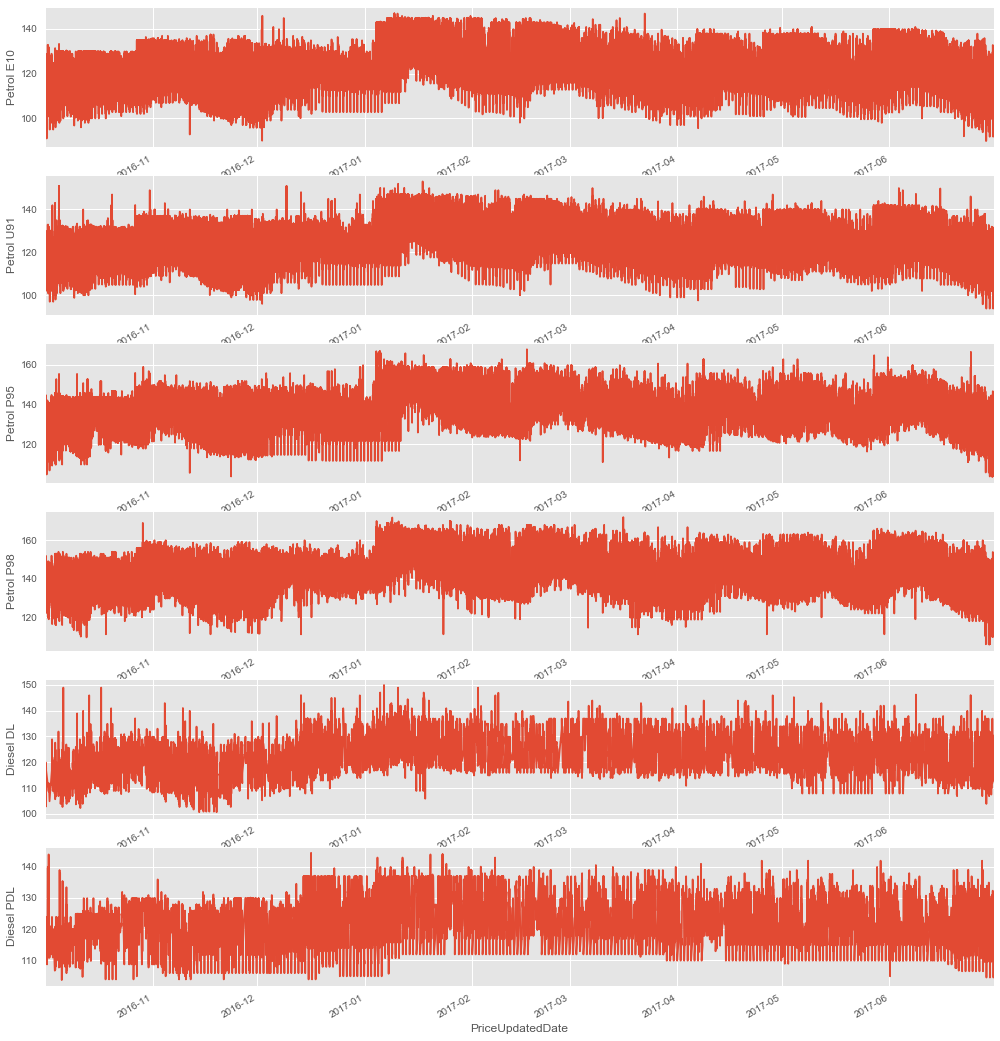

In [195]:
plt.subplot(611)
petrolE10Clean["Price"].plot()
plt.ylabel("Petrol E10")

plt.subplot(612)
petrolU91Clean["Price"].plot()
plt.ylabel("Petrol U91")

plt.subplot(613)
petrolP95Clean["Price"].plot()
plt.ylabel("Petrol P95")

plt.subplot(614)
petrolP98Clean["Price"].plot()
plt.ylabel("Petrol P98")

plt.subplot(615)
petrolDLClean["Price"].plot()
plt.ylabel("Diesel DL")

plt.subplot(616)
petrolPDLClean["Price"].plot()
plt.ylabel("Diesel PDL")

fig = plt.gcf()
fig.set_size_inches((17,20))

### 4. Resampling to averages

As we will be averaging the points to use in a predictive model, we are satisfied by the outlier removal above. We will now resample the data to a daily average.

In [196]:
# convert to daily average of price
petrolE10Daily = petrolE10Clean.resample('D').mean()
petrolU91Daily = petrolU91Clean.resample('D').mean()
petrolP95Daily = petrolP95Clean.resample('D').mean()
petrolP98Daily = petrolP98Clean.resample('D').mean()
petrolDLDaily = petrolDLClean.resample('D').mean()
petrolPDLDaily = petrolPDLClean.resample('D').mean()
# Checked works correctly: petrolE10Clean['2016-10-01'].mean() == petrolE10Daily.head()

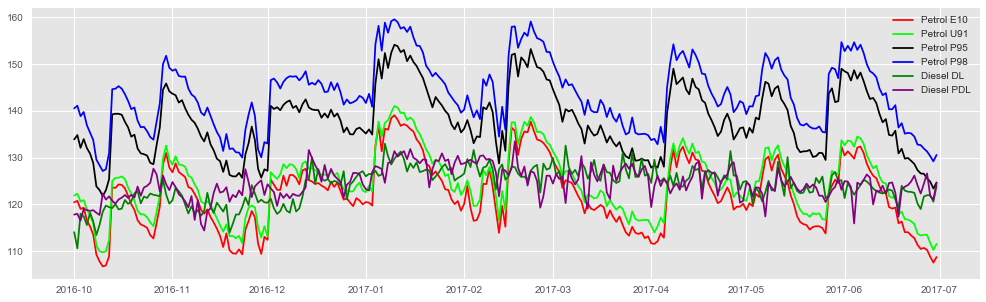

In [197]:
a = petrolE10Daily['Price']
b = petrolU91Daily['Price']
c = petrolP95Daily['Price']
d = petrolP98Daily['Price']
e = petrolDLDaily['Price']
f = petrolPDLDaily['Price']

#all
line1, = plt.plot(a, 'red', label="Petrol E10")
line2, = plt.plot(b, 'lime', label="Petrol U91")
line3, = plt.plot(c, 'black', label="Petrol P95")
line4, = plt.plot(d, 'blue', label="Petrol P98")
line5, = plt.plot(e, 'green', label="Diesel DL")
line6, = plt.plot(f, 'purple', label="Diesel PDL")

fig = plt.gcf()
fig.set_size_inches((17,5))
plt.legend(handles=[line1, line2, line3, line4, line5, line6], loc=1)

plt.show()

### 5. Seperation of unlike types

As we can see Diesel and Petrol don't have similar shapes. We will now seperate them better visualise the data.

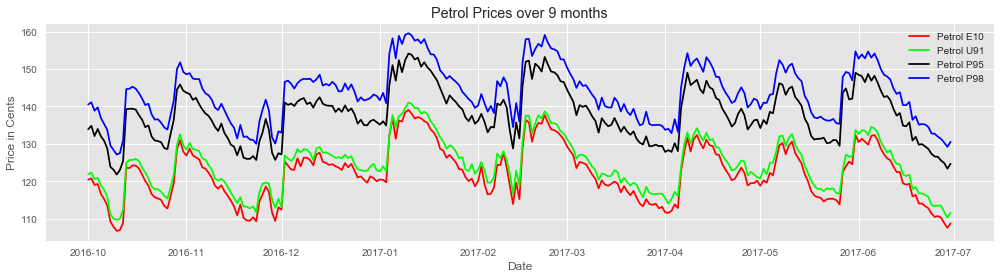

In [198]:
# petrol
plt.figure(2)
line1, = plt.plot(a, 'red', label="Petrol E10")
line2, = plt.plot(b, 'lime', label="Petrol U91")
line3, = plt.plot(c, 'black', label="Petrol P95")
line4, = plt.plot(d, 'blue', label="Petrol P98")
fig = plt.gcf()
fig.set_size_inches((17,4))
plt.title('Petrol Prices over 9 months')
plt.xlabel("Date")
plt.ylabel("Price in Cents")
plt.legend(handles=[line1, line2, line3, line4], loc=1)

plt.show()

### 6. Analysis of Correlation

From the above graph, we can see an expected result from petrol, with a similar shape shared aross the four datasets, with a constant difference. We can now confirm this statistically, using a correlation table.

In [199]:
# recombining dataframes
petrolE10Daily.drop('Postcode', axis=1, inplace=True)
petrolE10Daily.rename(columns={'Price':'E10'}, inplace=True)
petrolU91Daily.drop('Postcode', axis=1, inplace=True)
petrolU91Daily.rename(columns={'Price':'U91'}, inplace=True)
petrolP95Daily.drop('Postcode', axis=1, inplace=True)
petrolP95Daily.rename(columns={'Price':'P95'}, inplace=True)
petrolP98Daily.drop('Postcode', axis=1, inplace=True)
petrolP98Daily.rename(columns={'Price':'P98'}, inplace=True)

In [200]:
petrolDaily = pd.concat([petrolE10Daily, petrolU91Daily, petrolP95Daily, petrolP98Daily], axis=1)
petrolDaily.head()

,E10,U91,P95,P98
PriceUpdatedDate,,,,
2016-10-01,120.433103,121.864516,133.881545,140.514478
2016-10-02,120.738037,122.269976,134.798866,141.085490
2016-10-03,119.012446,120.595840,132.079519,138.844034
2016-10-04,119.259677,120.894603,133.951945,139.738804
2016-10-05,116.625884,118.865517,132.027422,136.921147


In [201]:
petrolDaily.corr()

,E10,U91,P95,P98
E10,1.000000,0.996627,0.990966,0.993166
U91,0.996627,1.000000,0.990079,0.991052
P95,0.990966,0.990079,1.000000,0.995955
P98,0.993166,0.991052,0.995955,1.000000


### 7. Calculation of Relationship

From the above correlation table, we can see our observation confirmed, with all the petrol types having a near maximum correlation. Having confirmed this, we can calculate the relationship difference between petrol types.

In [202]:
print("Average relationship of petrol types to regular Unleaded (U91): " + str(petrolDaily['U91'].mean()))
print("E10: " + str(petrolDaily['E10'].mean()-petrolDaily['U91'].mean()))
print("P95: " + str(petrolDaily['P95'].mean()-petrolDaily['U91'].mean()))
print("P98: " + str(petrolDaily['P98'].mean()-petrolDaily['U91'].mean()))

Average relationship of petrol types to regular Unleaded (U91): 124.45973481527895
E10: -2.3158151909896105
P95: 13.355170225355948
P98: 19.021456260124296


From the above calculation, we see that E10 is 2 cents cheaper, and P95 and P98 are 13 and 19 cents more expensive, than regular unleaded.

Proceeding to deisel...

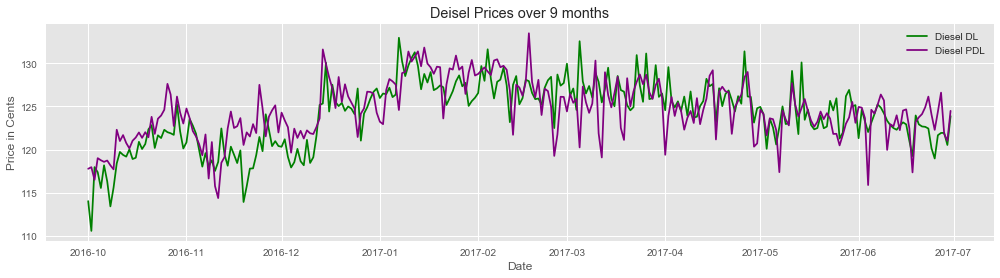

In [203]:
# diesel
plt.figure(3)
line5, = plt.plot(e, 'green', label="Diesel DL")
line6, = plt.plot(f, 'purple', label="Diesel PDL")
fig = plt.gcf()
fig.set_size_inches((17,4))
plt.title('Deisel Prices over 9 months')
plt.xlabel("Date")
plt.ylabel("Price in Cents")
plt.legend(handles=[line5, line6], loc=1)

plt.show()

### 8. Comments on Diesel

We see a surprising relationsip, as premium diesel is often cheaper than regular diesel. We can review the raw data to check for an explanation.

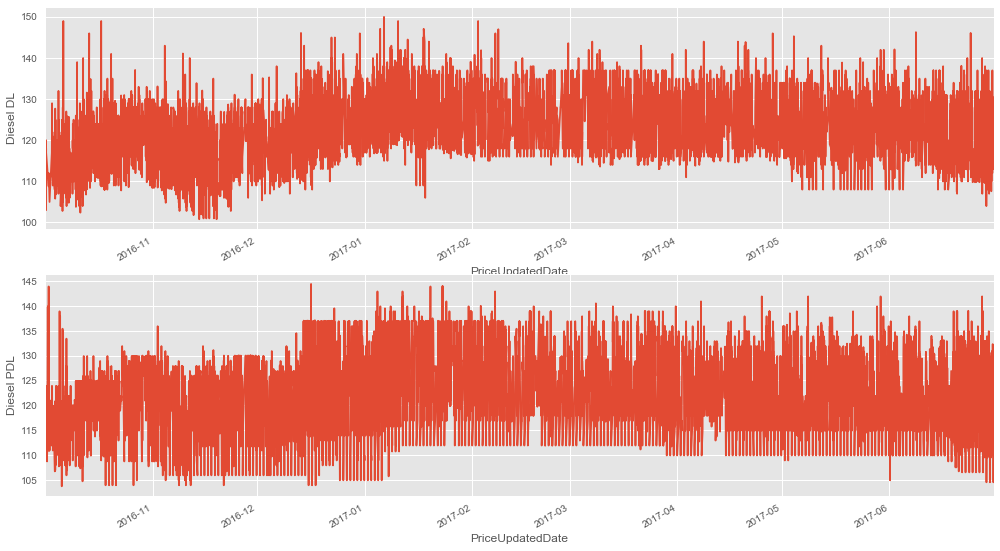

In [204]:
plt.subplot(211)
petrolDLClean["Price"].plot()
plt.ylabel("Diesel DL")

plt.subplot(212)
petrolPDLClean["Price"].plot()
plt.ylabel("Diesel PDL")

fig = plt.gcf()
fig.set_size_inches((17,10))
plt.show()

While the regular diesel shows a healthy (similiar to petrol) daily fluctuation between state brands and postcodes, premium diesel (PDL) has many constant outliers in the bottom price range. This may indicate a update error in the system, or a major baragain for cheap premium diesel. We will now try to isolate and remove these points to better view the relationship between regular and premium diesels.

In [205]:
petrolPDLClean['2017-01-15':'2017-03-15'].sort_values(by='Price').head()

,Postcode,Brand,FuelCode,Price
PriceUpdatedDate,,,,
2017-02-25 22:50:00,2045,Metro Fuel,PDL,111.9
2017-01-19 21:57:00,2216,Metro Fuel,PDL,111.9
2017-02-13 22:08:00,2216,Metro Fuel,PDL,111.9
2017-02-24 22:13:00,2216,Metro Fuel,PDL,111.9
2017-03-10 21:56:00,2216,Metro Fuel,PDL,111.9


In [206]:
petrolPDLClean['2017-05-05':'2017-05-30'].sort_values(by='Price').head()

,Postcode,Brand,FuelCode,Price
PriceUpdatedDate,,,,
2017-05-16 21:58:00,2045,Metro Fuel,PDL,109.9
2017-05-08 21:51:00,2045,Metro Fuel,PDL,109.9
2017-05-25 22:00:00,2045,Metro Fuel,PDL,109.9
2017-05-12 22:03:00,2045,Metro Fuel,PDL,109.9
2017-05-27 21:54:00,2045,Metro Fuel,PDL,109.9


Isolating two periods where this occurs, we find that the Metro Fuel Brand is resposible for these outliers. We will now remove this brand, an regraph the results for comparison.

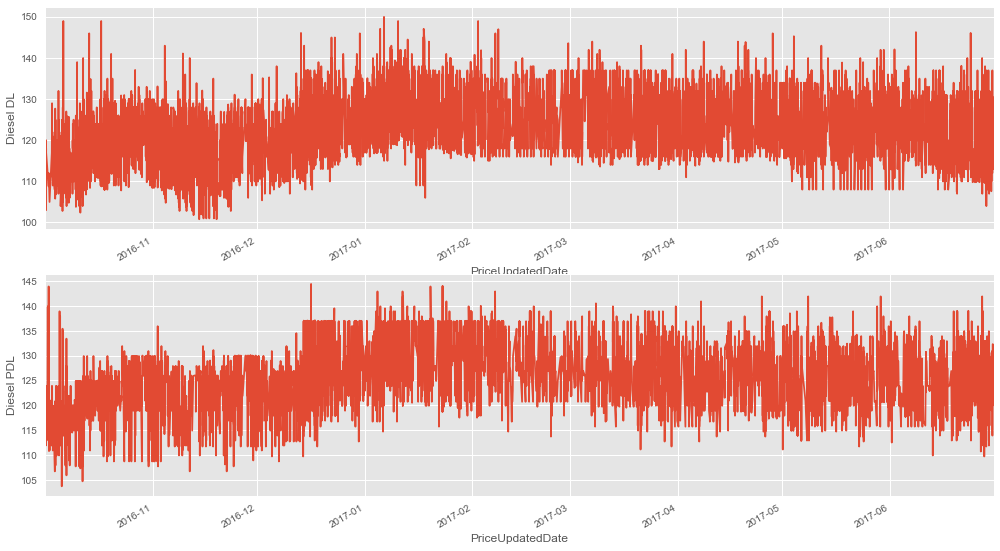

In [207]:
petrolPDLCleanRemoved = petrolPDLClean[petrolPDLClean.Brand != "Metro Fuel"]

plt.subplot(211)
petrolDLClean["Price"].plot()
plt.ylabel("Diesel DL")

plt.subplot(212)
petrolPDLCleanRemoved["Price"].plot()
plt.ylabel("Diesel PDL")

fig = plt.gcf()
fig.set_size_inches((17,10))

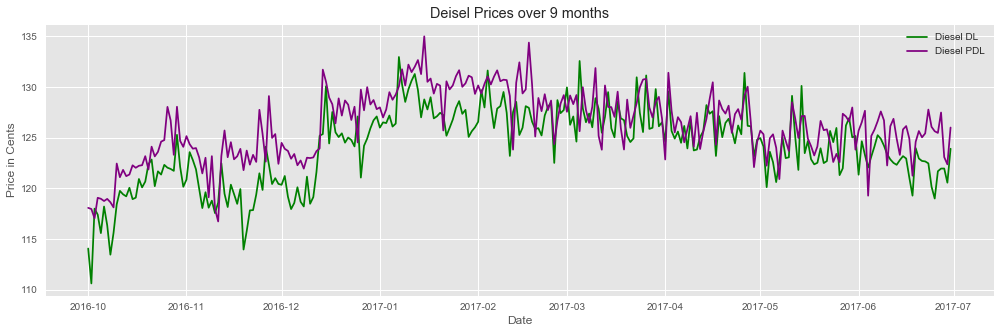

In [208]:
#reseampling from cleaned
petrolPDLDaily = petrolPDLCleanRemoved.resample('D').mean()
g = petrolPDLDaily['Price']

# diesel
plt.figure(3)
line5, = plt.plot(e, 'green', label="Diesel DL")
line6, = plt.plot(g, 'purple', label="Diesel PDL")
fig = plt.gcf()
fig.set_size_inches((17,5))
plt.title('Deisel Prices over 9 months')
plt.xlabel("Date")
plt.ylabel("Price in Cents")
plt.legend(handles=[line5, line6], loc=1)

plt.show()

While their are still some outliers present, these may be genuine bargain prices, and are too hard to isolate. Nonetheless we see that without Metro Fuel's premium diesel, more likeley price difference is visible.

We will now check the correlation between the two diesel types.

In [209]:
# recombining dataframes
petrolDLDaily.drop('Postcode', axis=1, inplace=True)
petrolDLDaily.rename(columns={'Price':'DL'}, inplace=True)
petrolPDLDaily.drop('Postcode', axis=1, inplace=True)
petrolPDLDaily.rename(columns={'Price':'PDL'}, inplace=True)

In [210]:
dieselDaily = pd.concat([petrolDLDaily, petrolPDLDaily], axis=1)
dieselDaily.head()

,DL,PDL
PriceUpdatedDate,,
2016-10-01,114.046154,118.060976
2016-10-02,110.600000,117.948485
2016-10-03,117.984127,117.037500
2016-10-04,117.396460,119.055449
2016-10-05,115.568889,118.957792


In [211]:
dieselDaily.corr()

,DL,PDL
DL,1.000000,0.797066
PDL,0.797066,1.000000


From the above table, we see that there is a much poorer correlation between diesel types, than petrol types. All petrol types were correllated by more than 99%, while diesel by only 79.7%. This may be attributed to outliers, such as Metro Fuel (which was already removed), as well as less volatile market, meaning data is less frequently updated (and as a result less accruate).

### 9. Relationship between Petrol and Crude Oil


We will now attempt to find a relationship between petrol prices and crude oil, and build a predictive model

In [212]:
petrolE10Daily.rename(columns={'E10': 'Petrol'}, inplace=True)
petrolU91Daily.rename(columns={'U91': 'Petrol'}, inplace=True)
petrolP95Daily.rename(columns={'P95': 'Petrol'}, inplace=True)
petrolP98Daily.rename(columns={'P98': 'Petrol'}, inplace=True)
petrolDLDaily.rename(columns={'DL': 'Diesel'}, inplace=True)
petrolPDLDaily.rename(columns={'PDL': 'Diesel'}, inplace=True)
crudeOil.rename(columns={'OIL/AUD': 'Crude Oil'}, inplace=True)

In [213]:
types = [petrolE10Daily, petrolU91Daily, petrolP95Daily, petrolP98Daily, petrolDLDaily, petrolPDLDaily, crudeOil]
priceMerge = pd.concat(types)
priceDaily = priceMerge.resample('D').mean()

In [214]:
priceDaily.head()

,Crude Oil,Diesel,Petrol
2016-10-01,62.7304,116.053565,129.173411
2016-10-02,62.5384,114.274242,129.723092
2016-10-03,63.4434,117.510813,127.632960
2016-10-04,64.5971,118.225954,128.461257
2016-10-05,65.2618,117.263341,126.109993


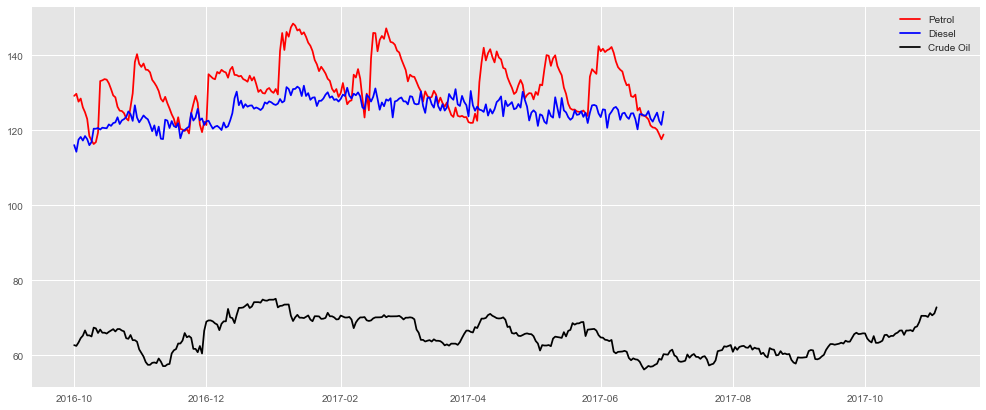

In [215]:
a = priceDaily['Petrol']
b = priceDaily['Diesel']
c = priceDaily['Crude Oil']

line1, = plt.plot(a, 'red', label="Petrol")
line2, = plt.plot(b, 'blue', label="Diesel")
line3, = plt.plot(c, 'black', label="Crude Oil")

fig = plt.gcf()
fig.set_size_inches((17,7))

# Create a legend for the first line.
plt.legend(handles=[line1, line2, line3], loc=1)

plt.show()

To examine a relationship, we will seperate the datalines by multiplying by a factor.

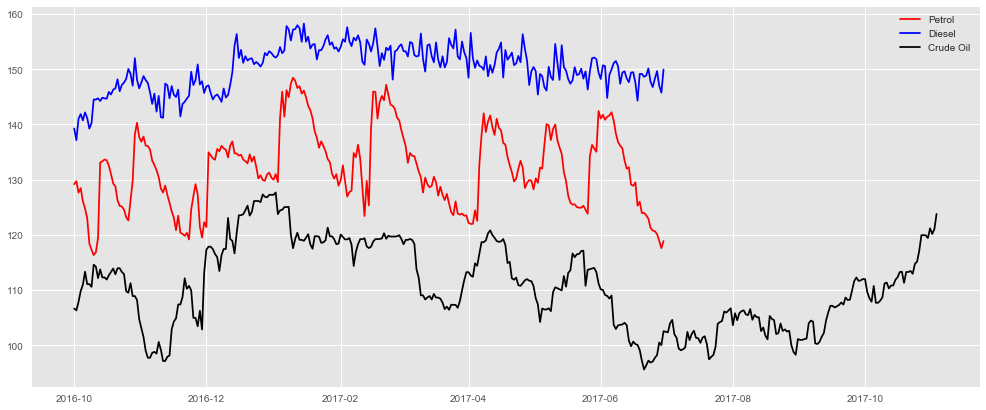

In [216]:
a = priceDaily['Petrol']
b = priceDaily['Diesel']*1.2
# shifting by week, and factoring up
c = priceDaily['Crude Oil']*1.7

line1, = plt.plot(a, 'red', label="Petrol")
line2, = plt.plot(b, 'blue', label="Diesel")
line3, = plt.plot(c, 'black', label="Crude Oil")
fig = plt.gcf()
fig.set_size_inches((17,7))

# Create a legend for the first line.
plt.legend(handles=[line1, line2, line3], loc=1)

plt.show()

In [217]:
priceDaily.corr()

,Crude Oil,Diesel,Petrol
Crude Oil,1.000000,0.473457,0.403444
Diesel,0.473457,1.000000,0.424105
Petrol,0.403444,0.424105,1.000000


From the above graph, we can observe that a relationship is visible, however there seems to be a lag (red peaks follow black). From the above correlation table, we see 0.47 and 0.40 correlation values to crude oil. We will now test if there is a lag, by testing correlation values for 7 days of shifting + and -.

In [218]:
petrolCorr = 0
petrolCorrShift = 0
dieselCorr = 0
dieselCorrShift = 0
for i in range(-14,14):
    crudeOilShifted = crudeOil.shift(freq=(str(i)+'D'))
    types = [petrolE10Daily, petrolU91Daily, petrolP95Daily, petrolP98Daily, petrolDLDaily, petrolPDLDaily, crudeOilShifted]
    priceMerge = pd.concat(types)
    priceDaily = priceMerge.resample('D').mean()
    if(priceDaily['Petrol'].corr(priceDaily['Crude Oil'])>petrolCorr):
        petrolCorr = priceDaily['Petrol'].corr(priceDaily['Crude Oil'])
        petrolCorrShift = i
    if(priceDaily['Diesel'].corr(priceDaily['Crude Oil'])>dieselCorr):
        dieselCorr = priceDaily['Diesel'].corr(priceDaily['Crude Oil'])
        dieselCorrShift = i
print("Max Correlation for petrol at " + str(petrolCorrShift*-1) + " day shift: " + str(petrolCorr))
print("Max Correlation for diesel at " + str(dieselCorrShift*-1) + " day shift: " + str(dieselCorr))

Max Correlation for petrol at -11 day shift: 0.604880505189
Max Correlation for diesel at -11 day shift: 0.678662373219


Our loop test has found that petrol and diesel both lag behind crude oil prices by 11 days. We will now regraph the data, applying these findings.

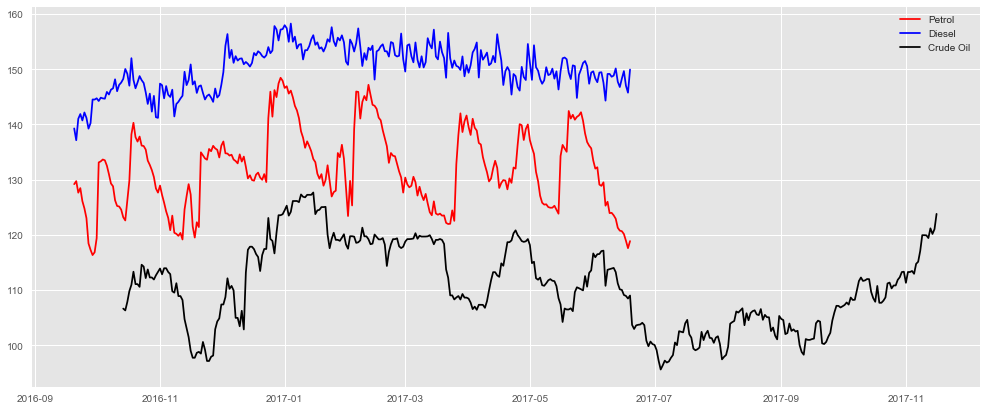

In [219]:
a = priceDaily['Petrol'].shift(freq='-11D')
b = priceDaily['Diesel'].shift(freq='-11D')*1.2
# shifting by week, and factoring up
c = priceDaily['Crude Oil']*1.7

line1, = plt.plot(a, 'red', label="Petrol")
line2, = plt.plot(b, 'blue', label="Diesel")
line3, = plt.plot(c, 'black', label="Crude Oil")
fig = plt.gcf()
fig.set_size_inches((17,7))

# Create a legend for the first line.
plt.legend(handles=[line1, line2, line3], loc=1)

plt.show()

In [220]:
#saving the shifts to the dataframe
petrolE10Shift = petrolE10Daily.shift(freq='-11D')
petrolU91Shift = petrolU91Daily.shift(freq='-11D')
petrolP95Shift = petrolP95Daily.shift(freq='-11D')
petrolP98Shift = petrolP98Daily.shift(freq='-11D')
petrolDLShift = petrolDLDaily.shift(freq='-11D')
petrolPDLShift = petrolPDLDaily.shift(freq='-11D')
types = [petrolE10Shift, petrolU91Shift, petrolP95Shift, petrolP98Shift, petrolDLShift, petrolPDLShift, crudeOil]
priceMerge = pd.concat(types)
priceDaily = priceMerge.resample('D').mean()

In [221]:
priceDaily = priceDaily['2016-10-01':'2017-11-03']
priceDaily.corr()

,Crude Oil,Diesel,Petrol
Crude Oil,1.000000,0.678662,0.604881
Diesel,0.678662,1.000000,0.378500
Petrol,0.604881,0.378500,1.000000


We can see a major improvement, with the major peaks lining up. We will now check the R2 values from Linear Regression Summaries.

In [222]:
# checking R square for all variables
variables = ["Diesel", "Petrol"]
for i in range(len(variables)):
    X = priceDaily["Crude Oil"]
    y = priceDaily[[variables[i]]]
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    print('Dependent: ', variables[i])
    print('      R2: ', model.rsquared)

Dependent:  Diesel
      R2:  0.460582616824
Dependent:  Petrol
      R2:  0.365880425558


From the above R2 values, we can conclude that it is not possible to predict petrol (or diesel) from global crude-oil prices. While there is a correlation between the datasets, it is not possible to predict furture values with just the one independent variable.

### 10.  Analysing Petrol Price by Location

As a secondary task, we have decided to analyse the effect of location on price. As we now know that each petrol type has a constant price difference (i.e. E10 to U91 etc.), we can isolate one type to work with. We have chosen to focus on E10, as it is the most common, with most data points.

In [223]:
petrolE10Clean.drop(['FuelCode'], axis=1, inplace=True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


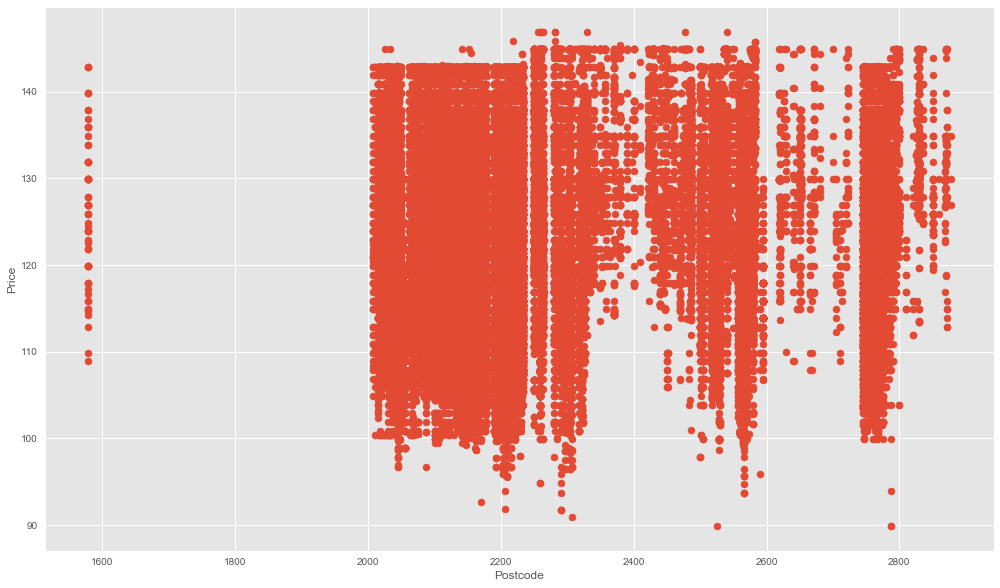

In [224]:
plt.scatter(petrolE10Clean['Postcode'], petrolE10Clean['Price'])
plt.xlabel("Postcode")
plt.ylabel("Price")
fig = plt.gcf()
fig.set_size_inches((17,10))

From the above graph, we can see a relationship between postcode and price. Vertical clusters have formed in densely populated areas (by group of postocodes), and each cluster has a different distribution of price.

We can further investgiate a location influence on price, by reducing the datapoint pool to postcode averages.

In [225]:
suburbBrandAverage.head()

,Price,lat,lon
Postcode,,,
2007,123.701250,-33.881391,151.196887
2011,124.926087,-33.870917,151.225285
2015,122.568937,-33.902086,151.196196
2016,123.277289,-33.892778,151.203901
2017,124.882796,-33.905169,151.206189


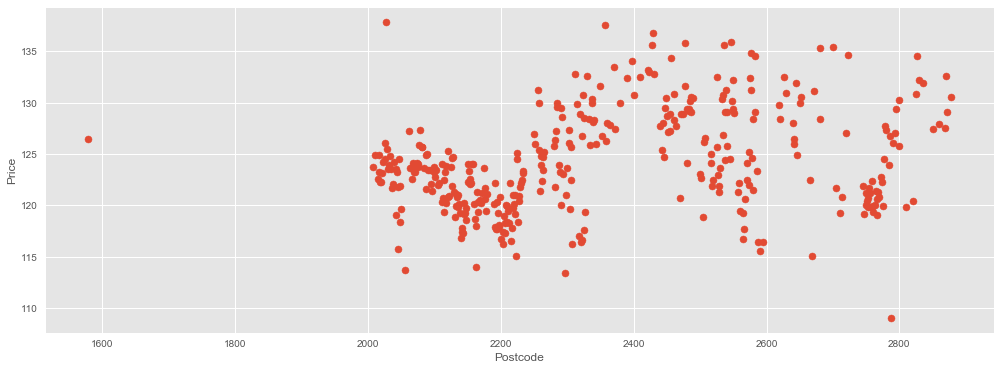

In [226]:
suburbAverage = petrolE10Clean.groupby('Postcode').mean()
plt.scatter(suburbAverage.index, suburbAverage['Price'])
plt.xlabel("Postcode")
plt.ylabel("Price")
fig = plt.gcf()
fig.set_size_inches((17,6))

In [ ]:
suburbAverage = petrolE10Clean.groupby('Postcode').mean()
plt.scatter(suburbAverage.index, suburbAverage['Price'])
plt.xlabel("Postcode")
plt.ylabel("Price")
fig = plt.gcf()
fig.set_size_inches((17,6))

We can see a clear variance of price based on postcode. While postcode is an indicator of location, the above scatter plot does not reflect information about the location geography. We will now attempt to plot the coordinates of each postcode.

In [227]:
postcodes = pd.read_csv('files/Postcodes/Australian_Post_Codes_Lat_Lon.csv', index_col=['suburb'])
postcodes.rename(columns={'postcode':'Postcode'}, inplace=True)
postcodes.rename(columns={'lat':'Lat'}, inplace=True)
postcodes.rename(columns={'lon':'Lon'}, inplace=True)
postcodes.head()

,Postcode,dc,Lat,Lon
suburb,,,,
AARONS PASS,2850,MUDGEE DC,-32.863277,149.803751
ABBOTSBURY,2176,LEIGHTONFIELD DF,-33.877538,150.867768
ABBOTSFORD,2046,LIDCOMBE DELIVERY CENTRE,-33.852469,151.129453
ABERCROMBIE RIVER,2795,BATHURST DELIVERY CENTRE,-33.911806,149.332781
ABERDARE,2325,CESSNOCK DC,-32.844200,151.376514


In [228]:
petrolE10 = pd.merge(petrolE10Clean, postcodes, on="Postcode")
suburbAverage = petrolE10.groupby(['Postcode']).mean()
suburbAverage.head()

,Price,Lat,Lon
Postcode,,,
2007,123.701250,-33.881391,151.196887
2011,124.926087,-33.870917,151.225285
2015,122.568937,-33.902086,151.196196
2016,123.277289,-33.892778,151.203901
2017,124.882796,-33.905169,151.206189


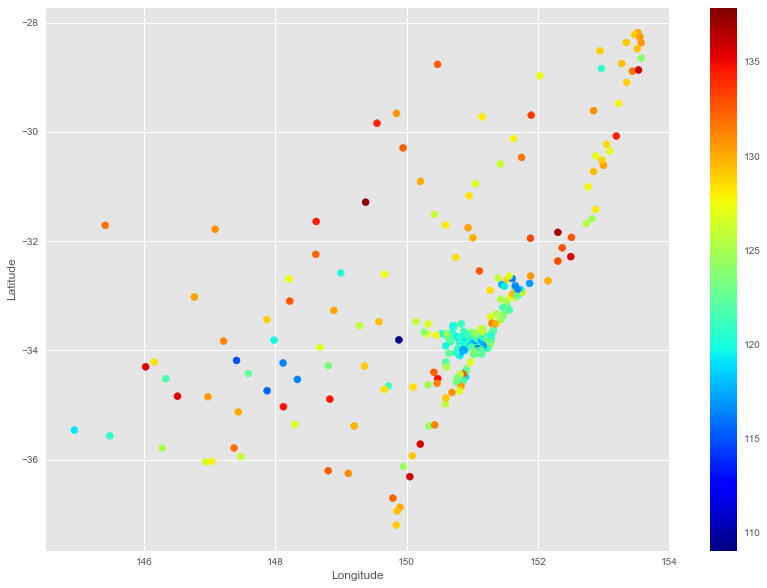

In [229]:
x = suburbAverage['Lon']
y = suburbAverage['Lat']
z = suburbAverage['Price']
plt.scatter(x, y, c=z, cmap='jet')
plt.colorbar()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
fig = plt.gcf()
fig.set_size_inches((14,10))
plt.show()

With the above graph showing a point per postcode, graphed geographcally (NSW), and showing a colour value for the average price, we see that there is little correlation between price and location. While competition in Sydney forces all petrol stations to have a similar price, the remaining stations throughout the state greatly vary, with averages of 110 and 130 beeing postcode neighbours.

# References

### Datasets
1. https://data.nsw.gov.au/data/dataset/a97a46fc-2bdd-4b90-ac7f-0cb1e8d7ac3b
2. https://au.investing.com/commodities/crude-oil-historical-data

### Coding References
